## MODEL 
* Install muna ako NVIDIA CUDA tas cuDNN para di sumabog PC 

In [5]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import json
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import PIL
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import load_img, img_to_array

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and will be used for training.")
else:
    print("No GPU found, training on CPU.")

GPU is available and will be used for training.


In [7]:
def load_images_and_labels(folder, label, target_size=(200, 200)):
    images = []
    labels = []
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

In [8]:
train_jaundiced_images, train_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class/train", 1)
train_healthy_images, train_healthy_labels = load_images_and_labels("./new/Normal Class/train", 0)

X_train = np.vstack((train_jaundiced_images, train_healthy_images))
y_train = np.hstack((train_jaundiced_labels, train_healthy_labels))

X_train, y_train = shuffle(X_train, y_train, random_state=1)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

# Load test data
test_jaundiced_images, test_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class/test", 1)
test_healthy_images, test_healthy_labels = load_images_and_labels("./new/Normal Class/test", 0)

X_test = np.vstack((test_jaundiced_images, test_healthy_images))
y_test = np.hstack((test_jaundiced_labels, test_healthy_labels))

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

# Load validation data
val_jaundiced_images, val_jaundiced_labels = load_images_and_labels("./new/Jaundiced Class/validate", 1)
val_healthy_images, val_healthy_labels = load_images_and_labels("./new/Normal Class/validate", 0)

X_val = np.vstack((val_jaundiced_images, val_healthy_images))
y_val = np.hstack((val_jaundiced_labels, val_healthy_labels))

print("Validation data shape:", X_val.shape)
print("Validation labels shape:", y_val.shape)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0


Training data shape: (847, 200, 200, 3)
Training labels shape: (847,)
Test data shape: (120, 200, 200, 3)
Test labels shape: (120,)
Validation data shape: (245, 200, 200, 3)
Validation labels shape: (245,)


In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=7, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model using GPU
with tf.device('/GPU:0'):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=16,
        callbacks=[early_stopping, lr_scheduler]
    )

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/50
53/53 [==============================] - 11s 51ms/step - loss: 1.8428 - accuracy: 0.7757 - val_loss: 0.6630 - val_accuracy: 0.6122 - lr: 5.0000e-04
Epoch 2/50
53/53 [==============================] - 2s 29ms/step - loss: 0.4659 - accuracy: 0.8937 - val_loss: 0.8512 - val_accuracy: 0.4653 - lr: 5.0000e-04
Epoch 3/50
53/53 [==============================] - 2s 29ms/step - loss: 0.3875 - accuracy: 0.9138 - val_loss: 0.6433 - val_accuracy: 0.6490 - lr: 5.0000e-04
Epoch 4/50
53/53 [==============================] - 2s 31ms/step - loss: 0.4553 - accuracy: 0.9091 - val_loss: 0.8988 - val_accuracy: 0.5633 - lr: 5.0000e-04
Epoch 5/50
53/53 [==============================] - 2s 30ms/step - loss: 0.3554 - accuracy: 0.9292 - val_loss: 0.9063 - val_accuracy: 0.6245 - lr: 5.0000e-04
Epoch 6/50
53/53 [==============================] - 1s 28ms/step - loss: 0.3407 - accuracy: 0.9197 - val_loss: 0.7707 - val_accuracy: 0.7102 - lr: 5.0000e-04
Epoch 7/50
53/53 [==============================] -

4/4 [==============================] - 0s 11ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        65
           1       0.96      1.00      0.98        55

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



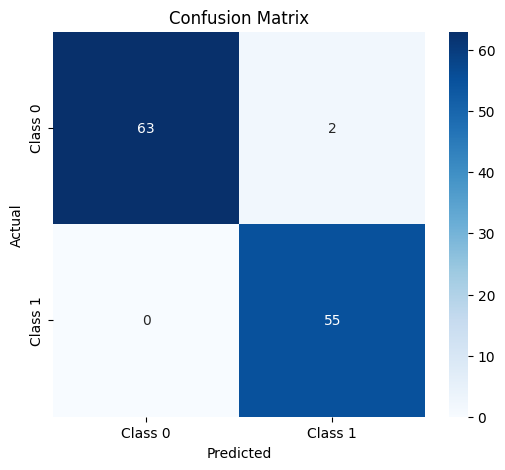

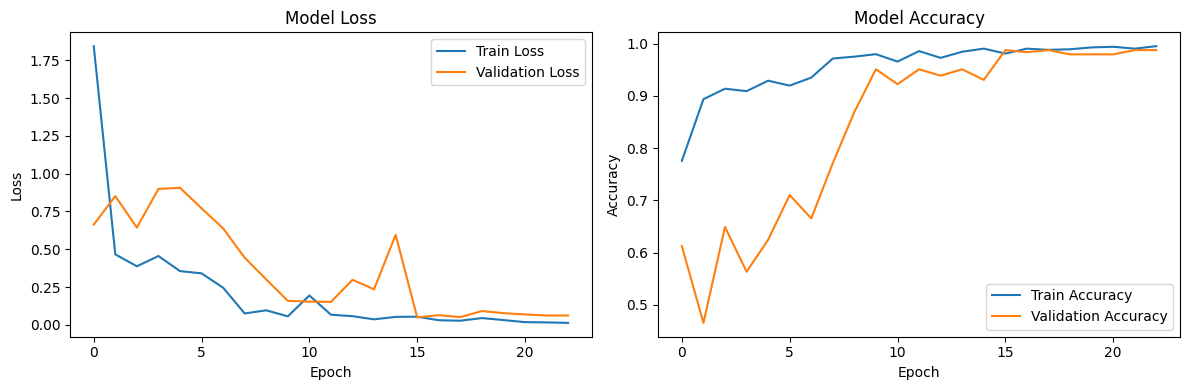

In [11]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot CM
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Loss and Accuracy Plots
plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
model.save("Jaundice_Classifier_CNN.h5") 